Do not forget to select a GPU Runtime before starting. 

The goal of this project is to perform simulation based inference with deep learning to constrain cosmological parameters. We will use the [CAMELS project](https://www.camel-simulations.org/). The Cosmology and Astrophysics with Machine Learning Simulations (CAMELS) is a suite of cosmological simulations with varying comsologies and subgrid physics, specially desgined for training Machine Learnning models. 

For this exercise we are going to use the [Multifield dataset](https://camels-multifield-dataset.readthedocs.io/en/latest/), which consists of a series of 2D Maps of different quantities (Stellar Mass, Total Mass, Gas Temperature, Velocity ...) for different cosmologies and subgrid parameters. 

**You can present the results in a pdf document together with a link to the code you used to generate the different plots, or as a colab document with approriate comments**

# Connect to GCloud

Just run these cells. Do not modify.

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  56377      0 --:--:-- --:--:-- --:--:-- 56377
OK
48 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.41.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.


In [3]:
!mkdir -p data
!gcsfuse --implicit-dirs -o allow_other -file-mode=777 -dir-mode=777 camels data


2022/05/24 01:43:53.483402 Start gcsfuse/0.41.1 (Go version go1.17.6) for app "" using mount point: /content/data
2022/05/24 01:43:53.528403 Opening GCS connection...
2022/05/24 01:43:53.822034 Mounting file system "camels"...
2022/05/24 01:43:53.825012 File system has been successfully mounted.


# Import python modules

In [4]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style

import tensorflow as tf
import tensorflow_probability as tfp
import sklearn
from sklearn import preprocessing
from astropy.visualization import ImageNormalize, MinMaxInterval
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score,auc,max_error

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator 

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
plt.style.use(astropy_mpl_style)
print(tfp.__version__)

0.16.0


#Load Maps and Corresponding parameters
The maps can be changed.

The models can be: 
 - IllustrisTNG
 -  SIMBA

The map types can be:
-  T (Gas Temperature)
-  Mstar (stellar mass)
- Z (Metallicity) 
-  Mgas (Gas Mass)
- Vgas (Gas Velocity)
- Mtot (total mass) etc..

The list of available files is in /content/data

In [5]:
## This function loads the maps and corresponding parameters

def load_maps(model,maptype):

  fmaps = '/content/data/Maps_'+maptype+'_'+model+'_LH_z=0.00.npy'
  maps  = np.load(fmaps)
  fparams = '/content/data/params_'+model+'.txt'
  params  = np.loadtxt(fparams)
  return maps,params

  

In [6]:
# loads the temperature map of Illustris TNG - can take a while
maps, params = load_maps('IllustrisTNG','T')

The following cell shows a random example of the loaded map together with the corresponding parameters. You can run it several times. The goal is to design a deep learning model to infer cosmological and astrophysical parameters using the different maps.

15000 256 256


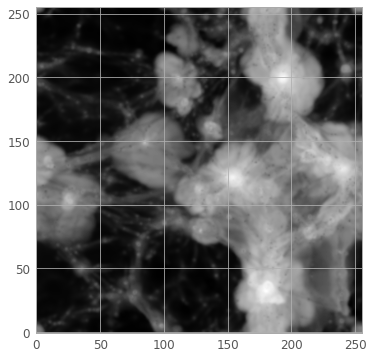

Value of the parameters for this map
Omega_m: 0.27580
sigma_8: 0.68460
A_SN1:   0.46329
A_AGN1:  0.70222
A_SN2:   1.11961
A_AGN2:  0.66021


In [7]:
from random import randrange
from random import sample
N,nrows,ncols = np.shape(maps)
print(N,nrows,ncols)
map_number = randrange(N)
plt.imshow(np.log10(maps[map_number]),cmap=plt.get_cmap('binary_r'), origin='lower', interpolation='bicubic')
plt.show()
params_map = params[map_number//15] ## This is how params and maps are connected. 
print('Value of the parameters for this map')
print('Omega_m: %.5f'%params_map[0])
print('sigma_8: %.5f'%params_map[1])
print('A_SN1:   %.5f'%params_map[2])
print('A_AGN1:  %.5f'%params_map[3])
print('A_SN2:   %.5f'%params_map[4])
print('A_AGN2:  %.5f'%params_map[5])

# Exercise 1: 
Create a Convolutional Neural Network that takes the map of gas temperature (T) from the IllustrisTNG model as input, and estimates $\Omega_m$ (the Dark Matter Density). The output of the Neural Network should be a Gaussian Probability Density Function. You can also experiment with multimodal Gaussians. This is similar to the exercice presented in [this notebook](https://github.com/mhuertascompany/ULL_2022/blob/main/hands-on/day3/Galaxy_Morphology_CNN_ULL22.ipynb) seen in class. You can follow the structire of that earlier notebook.

You will produce:
- A brief summary of the architecture used.
- A plot of the learning history including the training and the validation sets
- A plot of input vs. output on the test set, including error bars. You will use the mean of posterior as output. 
- Ten example plots of posterior distributions, together with the ground truth.
- 1-sigma value of the posterior versus the true error for the test set. Does the posterior properly capture uncertainty? Comment briefly.


Here is the first cell to get you started:

# Preparación de los Datos

En primer lugar vamos a separar nuestros datos en 3 grupos:
* xtrain/ytrain:Conjunto de datos con los que el modelo va a aprender o entrenar.
* xval/yval: conjunto de datos de validación. Estos datos se separan de los de entrenamiento ya que serán usadas para comprobar qué tan bien o qué tan mal se ha entrenado el modelo en cada epoch.
* xtest/ytest: Se separan estos datos de los entrenados para poder comprobar lo generalizado que sea nuestro modelo. Sirven para evaluar el modelo final.


para definir estos 3 grupos definimos una función a la que le proporcionamos como variables de entrada el número de datos que queremos en cada uno. Se han reducido los datos totales a 3000 para evitar problemas de memoria.

En la siguiente celda se muestra además un par de intentos por normalizar los datos y mejorar así el redimiento de la red. Ambos intentos han sido desestiemados finalmente puesto que los resueltados obtenidos no suponían una mejora en el procesamiento de los datos.



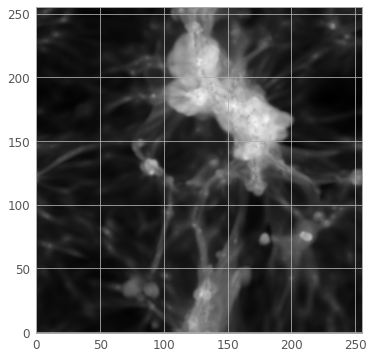

In [8]:

from sklearn.preprocessing import StandardScaler,  MinMaxScaler

def train_test(ntrain,nval,ntest):
  '''
  Normalización 1
  Y=np.array([])
  for i in range(maps.shape[0]):
    Y=np.append(Y,params[i//15][0])

  X, Y = sklearn.utils.shuffle(maps, Y)
  print(np.shape(X))

  
  for i in range(len(X)):
    X[i,:,:]=X[i,:,:]/np.max(X[i,:,:])
  scalerY =  MinMaxScaler().fit(Y.reshape((-1,1)))
  Ys = scalerY.transform(Y.reshape((-1,1)))
  Y_o=Y
  '''
  Y=[]
  for i in range(maps.shape[0]):
    Y.append(params[i//15][0])


  X, Y = sklearn.utils.shuffle(maps, Y)

  Xtrain=X[0:ntrain]
  Ytrain = Y[0:ntrain]

  Xval = X[ntrain:ntrain+nval]
  Yval = Y[ntrain:ntrain+nval]

  Xtest = X[ntrain+nval:ntrain+nval+ntest]
  Ytest = Y[ntrain+nval:ntrain+nval+ntest]

  return(np.asarray(Xtrain),np.asarray(Ytrain),np.asarray(Xval),np.asarray(Yval),np.asarray(Xtest),np.asarray(Ytest))
n_train = int((6/10)*(N/5))
n_val = int((2/10)*(N/5))
n_test =int((2/10)*(N/5))
x_train,y_train,x_val,y_val,x_test,y_test = train_test(n_train,n_val,n_test)


'''
#Normalización 2
mu_train = np.amax(x_train,axis=(1,2))
print(np.shape(x_train))

for i in range(0,mu_train.shape[0]):
    x_train[i,:,:] = x_train[i,:,:]/mu_train[i,]
   
mu_test = np.amax(x_test,axis=(1,2))
for i in range(0,mu_test.shape[0]):
    x_test[i,:,:] = x_test[i,:,:]/mu_test[i,]

mu_val = np.amax(x_val,axis=(1,2))
for i in range(0,mu_val.shape[0]):
    x_val[i,:,:] = x_val[i,:,:]/mu_val[i,]

print(np.max(x_train),np.min(x_train))
'''

plt.imshow(np.log10(x_train[0]),cmap=plt.get_cmap('binary_r'), origin='lower', interpolation='bicubic')



En las siguientes celdas se define la arquitectura de la red neuronal realizada en este trabajo. Para ello se ha empleado Tensorflow.

En primer lugar le decimos a la red que es secuencial, es decir, que vamos a tener varias capas. Y reescalamos la imagen empleando la función Resizing.

A continuación se enumeran algunos de los parámetros principales de entrada de la función de TensorFlow Conv2D, que son las capas convolucionales añadidas, en este caso han sido 3 capas. 
* número de filtros que vamos a aplicar en cada convolución, es decir después de cada convolución nuestra imagen tendrá una profuncidad de 128, 64 y 32. 
* tamaño del filtro. En nuestro caso, los tamaños de los filtros usados en nuestra convolución son (6,6) y (4,4)
* Con input le estamos diciendo las dimensiones de las imágenes.
* Se toma como función de activación 'relu'


Con tfkl.Flatten() le vamos a decir que nos haga la imagen plana, es decir que nos ponga en una dimensión toda la información de la red neuronal.

Con la línea tfkl.Dense(nb_dense, activation='tanh'), le estamos diciendo que tenemos nb_dense=128 neuronas y 64. Como función de activación se ha usado la función tangente hiperbólica.

Con la línea model.add(tfkl.Dropout(0.25)) le estamos diciendo que apague el 25% de las neuronas cada paso de forma aleatoria, para así evitar el overfitting y que busque todo el tiempo caminos alternos.

Con la función model.compile() se añaden los parámetros con los que vamos a optimizar nuestro algoritmo. En primer lugar le decimos que queremos que nuestra función de pérdida tenga una forma de probabilidad logarítmica negativa(negloglik), en segundo lugar le decimos que emplee el optimizador Adamax con un learning rate de 1e-4 (nos dice lo grandes que son los ajustes de la red al acercarse a una solución óptima) y finalmente le decimos que emplee como métrica para la optimización el porcentaje que nos dega lo bien que está aprendiendo nuestra red neuronal.

In [9]:

def CNN_Nair(img_rows, img_cols):
    
    model=tfk.Sequential()
    model.add(tfkl.Resizing(48, 48, input_shape=(img_rows, img_cols,1), name='Resize'))

    model.add(tfkl.Conv2D(128, (6,6),6, activation='relu',padding='same', name='Conv1'))
    model.add(tfkl.Conv2D(64, (6,6), 6, activation='relu',padding='same', name ='Conv2'))

    model.add(tfkl.BatchNormalization(name = 'Norm1'))  ## batch normalization layer

    model.add(tfkl.Conv2D(32,(4,4), 4,padding="same",activation ="relu", name ='Conv3'))

    model.add(tfkl.Flatten(name = 'Flatten'))

    model.add(tfkl.Dense(128, activation='tanh', name = 'Den1'))
    model.add(tfkl.Dense(64, activation='tanh', name = 'Den2'))


    model.add(tfkl.Dropout(0.1)) 
    # model.add(tfkl.Dense(tfpl.IndependentNormal.params_size(1), activation='tanh'))

    model.add(tfkl.Dense(tfpl.IndependentNormal.params_size(1), activation=None))
    model.add(tfpl.IndependentNormal(1,tfd.Normal.sample))  
    print("Compilation...")

    negloglik = lambda y, p_y: -p_y.log_prob(y)
    model.compile(loss=negloglik, optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-4), metrics=['mse'])   

    print("... done!")
    print("Model Summary")
    print("===================")
    model.summary()
    return model

# Definimos el modelo

In [10]:
# input image dimensions
img_rows, img_cols = x_train.shape[1:3]
#build model
cnn=CNN_Nair( img_rows, img_cols)

Compilation...
... done!
Model Summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Resize (Resizing)           (None, 48, 48, 1)         0         
                                                                 
 Conv1 (Conv2D)              (None, 8, 8, 128)         4736      
                                                                 
 Conv2 (Conv2D)              (None, 2, 2, 64)          294976    
                                                                 
 Norm1 (BatchNormalization)  (None, 2, 2, 64)          256       
                                                                 
 Conv3 (Conv2D)              (None, 1, 1, 32)          32800     
                                                                 
 Flatten (Flatten)           (None, 32)                0         
                                                                 
 Den1 (Dense)    

A continuación se definen los parámetros de entrada para el entrenamiento de la red. Con cnn.fit se le pide que entrene con los parámetros de entrada x_train e y_train. Con batch_size = 32 le decimos el número de imágenes que mandamos a procesas en cada uno de los pasos, con epochs=nb_epoch le decimos el número de veces que vamos a iterar sobre todo el set de datos durante el entrenamiento,con validation_data=(x_val, y_val) le añadimos los datos de validación y con shuffle=True le estamos diciendo que mezcle las imágenes.

In [11]:
pathout='entregable/models/model1'
model_name = '/cnn_entrega'   

LOAD_MODEL=False

batch_size = 32 # número de imágenes que mandamos a procesas en cada uno de los pasos
nb_epoch = 150  #número de veces que vamos a iterar sobre todo el set de datos durante el entrenamiento
data_augmentation = False



patience_par=15
earlystopping = EarlyStopping(monitor='val_loss',patience = patience_par,verbose=0,mode='auto' )
modelcheckpoint = ModelCheckpoint(pathout+model_name+"_best.hd5",monitor='val_loss',verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir=pathout)


if LOAD_MODEL:
  cnn.load_weights(pathout+model_name+'.hd5')


if not data_augmentation:
  print('Not using data augmentation.')
  history = cnn.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=nb_epoch,
                            validation_data=(x_val, y_val),
                            shuffle=True,
                            callbacks=[earlystopping])
else:
  print('Using real-time data augmentation.')


  datagen = ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center=False, 
            featurewise_std_normalization=False, 
            samplewise_std_normalization=False,
            zca_whitening=False, 
            rotation_range=25,
            width_shift_range=0.1,  
            height_shift_range=0.1, 
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=[0.75,1.3])  

  x_train =x_train.reshape(np.shape(x_train)[0], np.shape(x_train)[1],np.shape(x_train)[2], 1)
 
  datagen.fit(x_train)
        
  history = cnn.fit_generator(
                    datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=batch_size,
                    epochs=nb_epoch,
                    validation_data=(x_val, y_val),
                    callbacks=[earlystopping]
                )



print("Saving model...")
cnn.save_weights(pathout+model_name+".hd5",overwrite=True)

Not using data augmentation.
Epoch 1/150
57/57 [==============================] - 14s 25ms/step - loss: 0.3657 - mse: 0.3479 - val_loss: 0.1991 - val_mse: 0.2384
Epoch 2/150
57/57 [==============================] - 1s 11ms/step - loss: 0.1057 - mse: 0.1619 - val_loss: 0.0289 - val_mse: 0.1798
Epoch 3/150
57/57 [==============================] - 1s 11ms/step - loss: 0.0050 - mse: 0.1481 - val_loss: -0.0800 - val_mse: 0.1347
Epoch 4/150
57/57 [==============================] - 1s 12ms/step - loss: -0.1289 - mse: 0.1154 - val_loss: -0.1601 - val_mse: 0.1078
Epoch 5/150
57/57 [==============================] - 1s 12ms/step - loss: -0.1503 - mse: 0.1032 - val_loss: -0.2429 - val_mse: 0.1092
Epoch 6/150
57/57 [==============================] - 1s 12ms/step - loss: -0.2079 - mse: 0.0894 - val_loss: -0.2973 - val_mse: 0.0957
Epoch 7/150
57/57 [==============================] - 1s 12ms/step - loss: -0.2626 - mse: 0.0876 - val_loss: -0.3559 - val_mse: 0.0772
Epoch 8/150
57/57 [==================

A continuación se representa el valor de la función de pérdidas para los datos de validación (rojo) y los valores de la función de pérdidas para los datos de entrenamiento, por época. Un buen indicativo de que nuestra red neurona está trabajando correctamente sería que las funciones de pérdidas tendiesen a -1 en el menor número de épocas posibles y se estabilizase rápidamente. Sin embargo, aunque la tendencia es decreciente (lo cual nos indica que el modelo está aprendiendo) se muestran pequeñs variaciones. Ambos valores parece que tiene una tendencia estable, por lo que dejarlo entrenar más en este caso no supondría una mejora.

Text(0, 0.5, 'Loss')

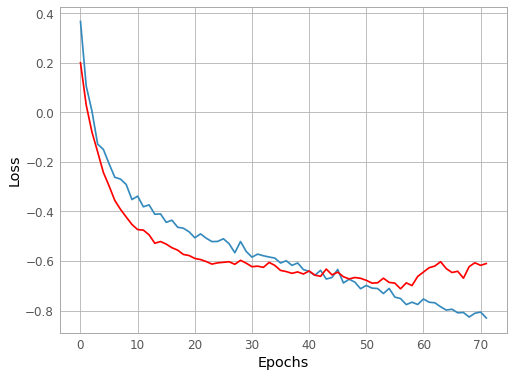

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Esquema de la red neuronal realizada

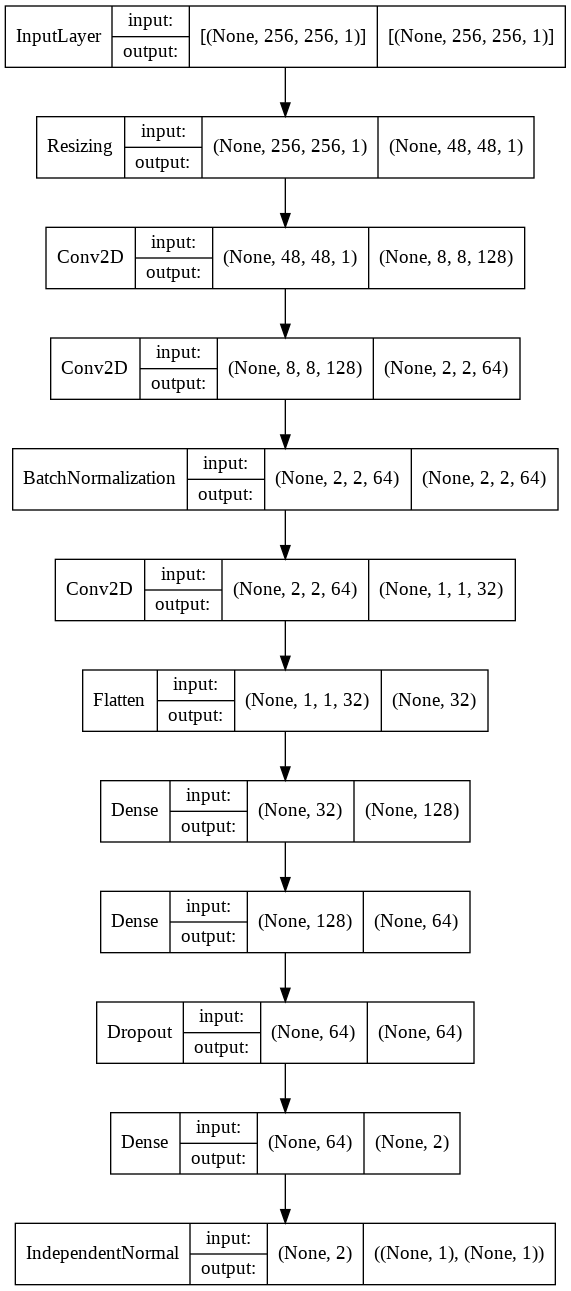

In [13]:
from keras.utils.vis_utils import plot_model

plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

Se ha representado además un histograma para mostrar la forma de los datos. Una buena predicción haría que ambos (los valores de prueba y los predecidos) se parecieran bastante. Vemos que efectivamente poseen formas similares por lo que puede ser un buen indicativo.

Predicting...


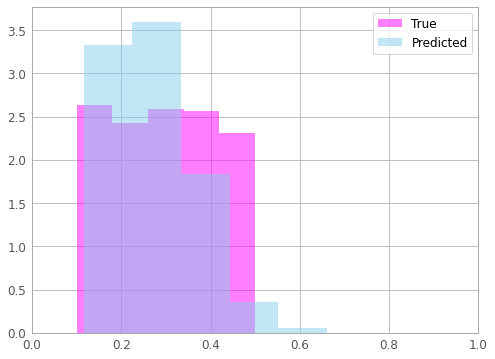

In [14]:
print("Predicting...")
print("====================")
LOAD_MODEL=False


Y_pred_DL = cnn(x_test)
plt.hist(y_test,label='True',alpha=0.5,density=True,bins=5,stacked=True,color='magenta')
plt.hist(np.asarray(Y_pred_DL.mean()),label='Predicted',alpha=0.5,density=True,bins=5,color='skyblue')
plt.xlim(0,1)
plt.legend()


Para saber realmente si nuestro modelo funciona correctamente se ha realizado una comparación de los valores predichos por el modelo frente a los valores reales. Un predicción perfecta nos daría una relación 1-1. Por ello se ha representado en rojo una recta de pendiente 1. Aunque los valores no son perfectos se aprecia cierta tendencia lineal y además vemos que las barras de error tocan la línea roja del modelo perfecto, por lo que podemos decir que los resultados son razonables.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


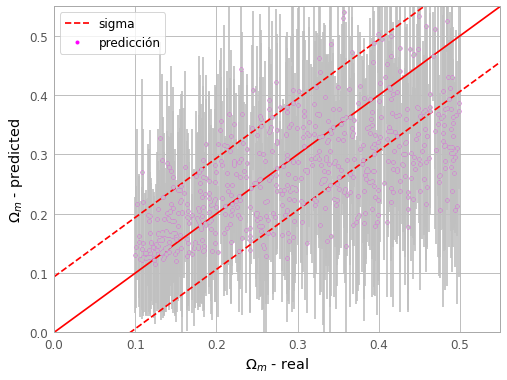

In [15]:
Y_pred_DL = cnn(x_test)

ypred=np.asarray(Y_pred_DL.mean())
error=np.asarray(Y_pred_DL.stddev())


plt.errorbar(y_test,ypred,yerr=error,color='silver',fmt='.')
plt.xlabel('$\\Omega_m$ - real')
plt.ylabel('$\\Omega_m$ - predicted')
plt.plot(np.linspace(0,0.6,10),np.linspace(0,0.6,10),'r-')
plt.plot(np.linspace(0,0.6,600),np.linspace(0,0.6,600)+np.std(ypred),'r--',label='sigma')
plt.plot(np.linspace(0,0.6,10),np.linspace(0,0.6,10)-np.std(ypred),'r--')
plt.plot(y_test, ypred, '.',color='magenta', label = 'predicción')
plt.ylim(0,0.55)
plt.xlim(0,0.55)
plt.legend()

A continuación se muestran dos formas diferentes de obtener la posterior distributions, para ser comparados con los valores reales. En primer lugar se han aproximado a una distribución normal (gausiana), empleando el valor medio de los datos pedichos como máximo de la función y la desviación estandar como la anchura de la gausiana de dichos datos. Se han representado con lineas sólidas los valores predichos y con lienas discontínuas los reales.

Seguidamente se ha realizando empleando la función log_prob que devuelve el logaritmo de la densidad de probabilidad.

En ambos casos se observan resultados en los que el valor esperado se encuentra cerca del máximo de la distribución de probabilidad y casos en los ésta se encuentra algo más alejada.

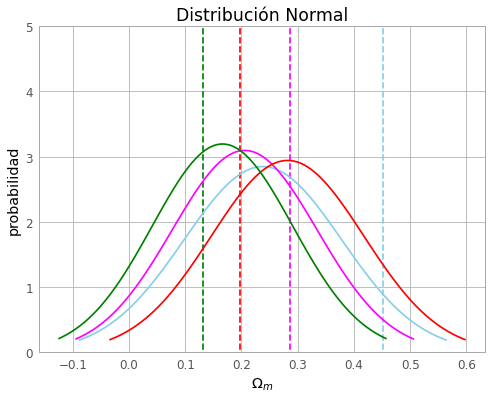

In [16]:

from scipy.stats import norm
import random
mu, sigma = ypred, error # media y desvio estandar
mu=mu[:,-1]
sigma=sigma[:,-1]

indice=np.array([])
indice = random.sample(range(0,len(mu)-1), 5)
newmu = np.array([])
newsigma = np.array([])
y_prueba = np.array([])
for i in indice:
  newmu = np.append(newmu, mu[i])
  newsigma = np.append(newsigma, sigma[i])
  y_prueba=np.append(y_prueba, y_test[indice])
mu = newmu
sigma=newsigma


normal = norm(mu, sigma)
x = np.linspace(normal.ppf(0.01),normal.ppf(0.99), 100)
fp = normal.pdf(x) # Función de Probabilidad
plt.plot(x[:,0], fp[:,0], color='skyblue')
plt.vlines(y_prueba[0],ymin=-3,ymax=7,linestyle='--', color='skyblue')

plt.plot(x[:,1], fp[:,1], color='magenta')
plt.vlines(y_prueba[1],ymin=-3,ymax=7,linestyle='--', color='magenta')

plt.plot(x[:,2], fp[:,2], color='red')
plt.vlines(y_prueba[2],ymin=-3,ymax=7,linestyle='--', color='red')

plt.plot(x[:,3], fp[:,3], color='green')
plt.vlines(y_prueba[3],ymin=-3,ymax=7,linestyle='--', color='green')

plt.title('Distribución Normal')
plt.ylabel('probabilidad')
plt.xlabel('$\Omega_m$')
#plt.legend(['$\Omega_m$='+str(a) for a in y_test[indice]])
plt.ylim(0,5)
plt.show()

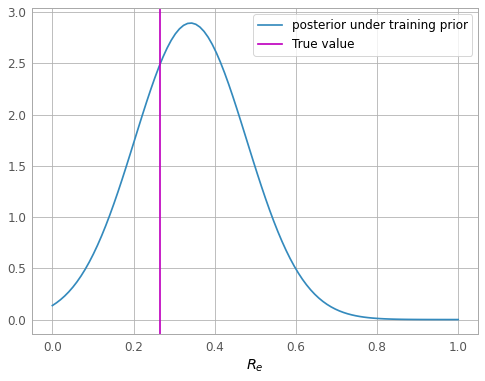

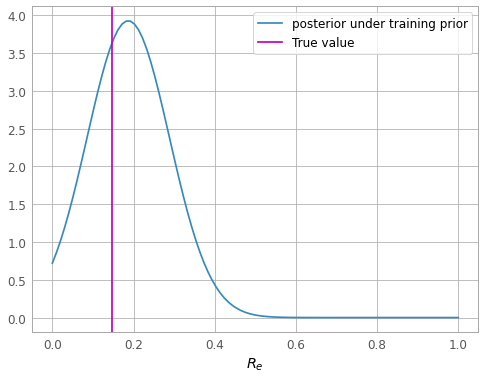

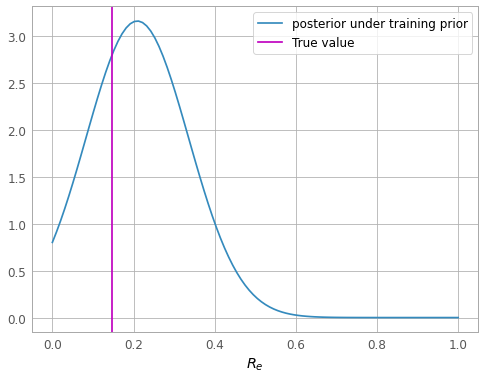

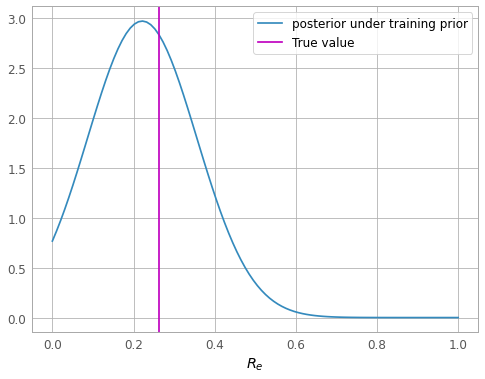

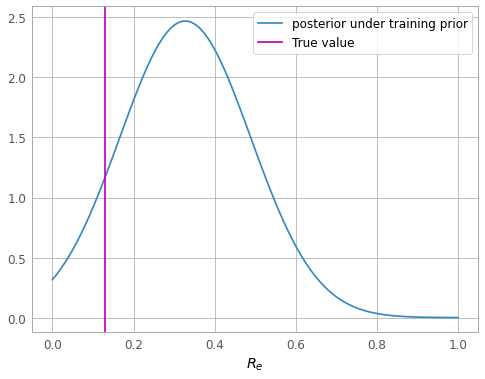

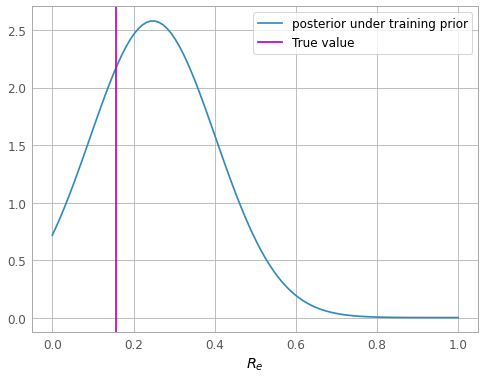

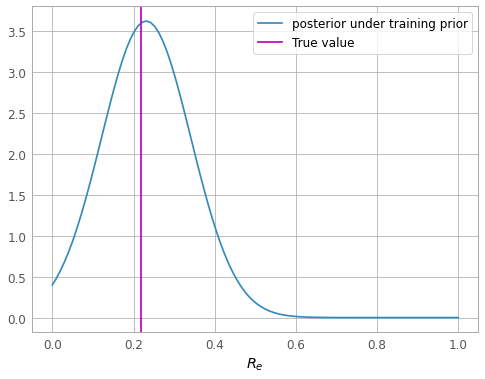

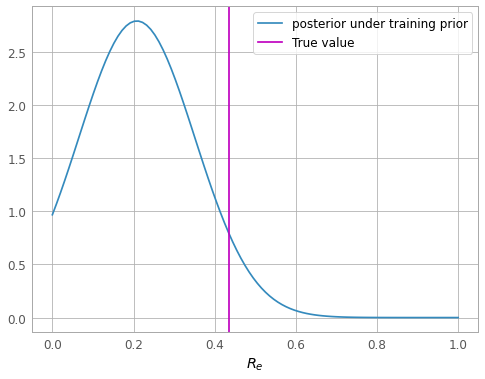

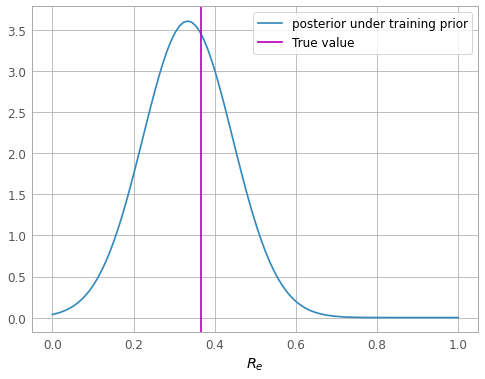

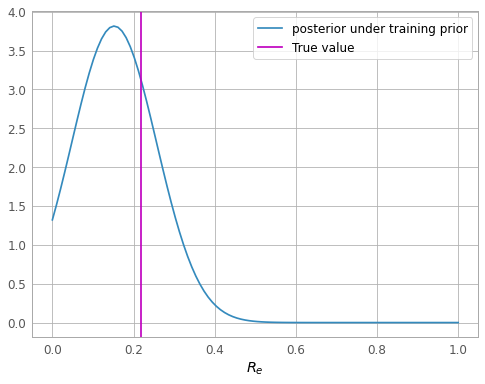

In [17]:

outputs = cnn(x_test)
size = np.linspace(0, 1,100)
logps = []

for i in range(len(size)):
    logps.append(outputs.log_prob(size[i]).numpy())
logps = np.stack(logps)

for i in range(10):
  plt.figure()
  plt.plot(size, np.exp(logps[:,-i]), label='posterior under training prior')
  plt.axvline(y_test[-i], color='m', label='True value')
  plt.xlabel(r'$R_e$')
  plt.legend()

Finalmente se representa las sigmas, los errores, proporcionados por el modelo frente a las desviaciones de los datos predichos frente a los datos reales, aplicando la propia definición de la desviación estándar. Se esperaría que tuvieran una relación 1:1, sin embargo esto no es así.

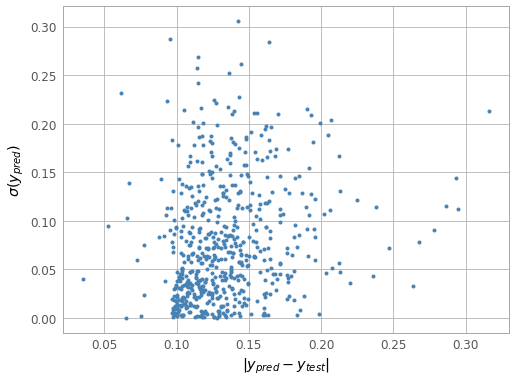

In [18]:
# Cálculo del error real

realError = np.array([])

for i in range(len(ypred)):
  realError = np.abs(np.append(realError, ypred[i] - y_test[i]))

plt.figure()
plt.plot(error, realError, '.', color='steelblue')
plt.xlabel(r"$\vert y_{pred}- y_{test} \vert$")
plt.ylabel(r"$\sigma(y_{pred})$")
plt.show()

# Before starting Exercise 2: 
*** You will likely run out of memory if you proceed straight to exercise 2.  As can be seen in the [notebook](https://github.com/mhuertascompany/ULL_2022/blob/main/hands-on/day3/Galaxy_Morphology_CNN_ULL22.ipynb), you can save the weights of the previous training (model.save_weights) in your GDrive. Then restart the notebook and load those weights.:

print("Saving model...")

cnn.save_weights(pathout+model_name+".hd5",overwrite=True)

then

cnn.load_weights(pathout+model_name+".hd5")

# Exercise 2:
Test the deep learning model on the same map, produced now with the SIMBA cosmological model. 

- Produce a scatter plot, including error bars, of input Omega_m versus output Omega_m. Comment.
- Plot ten example plots of posterior distributions
- Plot the 1-sigma value of the posterior versus the true error. Does the posterior properly capture uncertainty? Comment.

In [19]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style

import tensorflow as tf
import tensorflow_probability as tfp
import sklearn
from sklearn import preprocessing
from astropy.visualization import ImageNormalize, MinMaxInterval
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score,auc,max_error

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator 

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
plt.style.use(astropy_mpl_style)
print(tfp.__version__)

0.16.0


In [20]:
## This function loads the maps and corresponding parameters

def load_maps(model,maptype):

  fmaps = '/content/data/Maps_'+maptype+'_'+model+'_LH_z=0.00.npy'
  maps  = np.load(fmaps)
  fparams = '/content/data/params_'+model+'.txt'
  params  = np.loadtxt(fparams)
  return maps,params


In [19]:
# loads the temperature map of Illustris TNG - can take a while
maps, params = load_maps('SIMBA','T')

15000 256 256


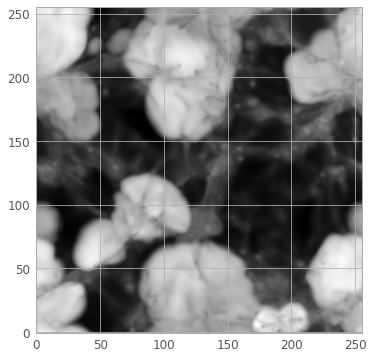

Value of the parameters for this map
Omega_m: 0.17220
sigma_8: 0.87340
A_SN1:   2.43851
A_AGN1:  3.76853
A_SN2:   1.39959
A_AGN2:  0.89440


In [20]:
from random import randrange
from random import sample
N,nrows,ncols = np.shape(maps)
print(N,nrows,ncols)
map_number = randrange(N)
plt.imshow(np.log10(maps[map_number]),cmap=plt.get_cmap('binary_r'), origin='lower', interpolation='bicubic')
plt.show()
params_map = params[map_number//15] ## This is how params and maps are connected. 
print('Value of the parameters for this map')
print('Omega_m: %.5f'%params_map[0])
print('sigma_8: %.5f'%params_map[1])
print('A_SN1:   %.5f'%params_map[2])
print('A_AGN1:  %.5f'%params_map[3])
print('A_SN2:   %.5f'%params_map[4])
print('A_AGN2:  %.5f'%params_map[5])

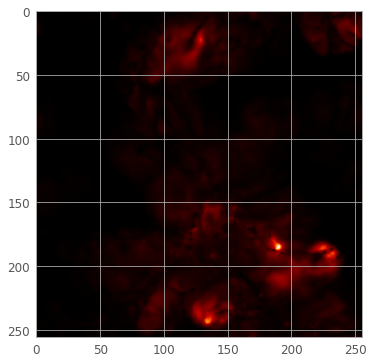

In [21]:

from sklearn.preprocessing import StandardScaler,  MinMaxScaler


def train_test(ntrain,nval,ntest):
  Y=[]
  for i in range(maps.shape[0]):
    Y.append(params[i//15][0])


  X, Y = sklearn.utils.shuffle(maps, Y)

  Xtrain=X[0:ntrain]
  Ytrain = Y[0:ntrain]

  Xval = X[ntrain:ntrain+nval]
  Yval = Y[ntrain:ntrain+nval]

  Xtest = X[ntrain+nval:ntrain+nval+ntest]
  Ytest = Y[ntrain+nval:ntrain+nval+ntest]

  return(np.asarray(Xtrain),np.asarray(Ytrain),np.asarray(Xval),np.asarray(Yval),np.asarray(Xtest),np.asarray(Ytest))
n_train = int((6/10)*(N/5))
n_val = int((2/10)*(N/5))
n_test =int((2/10)*(N/5))
x_train,y_train,x_val,y_val,x_test,y_test = train_test(n_train,n_val,n_test)

plt.imshow(x_train[0])


In [22]:

def CNN_Nair(img_rows, img_cols):
    
    model=tfk.Sequential()
    model.add(tfkl.Resizing(48, 48, input_shape=(img_rows, img_cols,1), name='Resize'))

    model.add(tfkl.Conv2D(128, (6,6),6, activation='relu',padding='same', name='Conv1'))
    model.add(tfkl.Conv2D(64, (6,6), 6, activation='relu',padding='same', name ='Conv2'))

    model.add(tfkl.BatchNormalization(name = 'Norm1'))  ## batch normalization layer

    model.add(tfkl.Conv2D(32,(4,4), 4,padding="same",activation ="relu", name ='Conv3'))

    model.add(tfkl.Flatten(name = 'Flatten'))

    model.add(tfkl.Dense(128, activation='tanh', name = 'Den1'))
    model.add(tfkl.Dense(64, activation='tanh', name = 'Den2'))


    model.add(tfkl.Dropout(0.1)) 
    # model.add(tfkl.Dense(tfpl.IndependentNormal.params_size(1), activation='tanh'))

    model.add(tfkl.Dense(tfpl.IndependentNormal.params_size(1), activation=None))
    model.add(tfpl.IndependentNormal(1,tfd.Normal.sample))  
    print("Compilation...")

    negloglik = lambda y, p_y: -p_y.log_prob(y)
    model.compile(loss=negloglik, optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-4), metrics=['mse'])   

    print("... done!")
    print("Model Summary")
    print("===================")
    model.summary()
    return model

In [23]:
# input image dimensions
img_rows, img_cols = x_train.shape[1:3]
#build model
cnn=CNN_Nair( img_rows, img_cols)

Compilation...
... done!
Model Summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Resize (Resizing)           (None, 48, 48, 1)         0         
                                                                 
 Conv1 (Conv2D)              (None, 8, 8, 128)         4736      
                                                                 
 Conv2 (Conv2D)              (None, 2, 2, 64)          294976    
                                                                 
 Norm1 (BatchNormalization)  (None, 2, 2, 64)          256       
                                                                 
 Conv3 (Conv2D)              (None, 1, 1, 32)          32800     
                                                                 
 Flatten (Flatten)           (None, 32)                0         
                                                                 
 Den1 (Dense)  

In [24]:
pathout='entregable/models/model1'
model_name = '/cnn_entrega'   

LOAD_MODEL=False

batch_size = 32 # número de imágenes que mandamos a procesas en cada uno de los pasos
nb_epoch = 150  #número de veces que vamos a iterar sobre todo el set de datos durante el entrenamiento
data_augmentation = False



patience_par=15
earlystopping = EarlyStopping(monitor='val_loss',patience = patience_par,verbose=0,mode='auto' )
modelcheckpoint = ModelCheckpoint(pathout+model_name+"_best.hd5",monitor='val_loss',verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir=pathout)


if LOAD_MODEL:
  cnn.load_weights(pathout+model_name+'.hd5')


if not data_augmentation:
  print('Not using data augmentation.')
  history = cnn.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=nb_epoch,
                            validation_data=(x_val, y_val),
                            shuffle=True,
                            callbacks=[earlystopping])
else:
  print('Using real-time data augmentation.')


  datagen = ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center=False, 
            featurewise_std_normalization=False, 
            samplewise_std_normalization=False,
            zca_whitening=False, 
            rotation_range=25,
            width_shift_range=0.1,  
            height_shift_range=0.1, 
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=[0.75,1.3])  

  x_train =x_train.reshape(np.shape(x_train)[0], np.shape(x_train)[1],np.shape(x_train)[2], 1)
 
  datagen.fit(x_train)
        
  history = cnn.fit_generator(
                    datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=batch_size,
                    epochs=nb_epoch,
                    validation_data=(x_val, y_val),
                    callbacks=[earlystopping]
                )



print("Saving model...")
cnn.save_weights(pathout+model_name+".hd5",overwrite=True)

Not using data augmentation.
Epoch 1/150
57/57 [==============================] - 2s 17ms/step - loss: 0.4643 - mse: 0.3772 - val_loss: 0.4761 - val_mse: 0.3790
Epoch 2/150
57/57 [==============================] - 1s 11ms/step - loss: 0.2283 - mse: 0.2362 - val_loss: 0.4704 - val_mse: 0.4276
Epoch 3/150
57/57 [==============================] - 1s 11ms/step - loss: 0.0057 - mse: 0.1510 - val_loss: 0.4187 - val_mse: 0.3452
Epoch 4/150
57/57 [==============================] - 1s 11ms/step - loss: -0.0844 - mse: 0.1099 - val_loss: 0.3909 - val_mse: 0.3295
Epoch 5/150
57/57 [==============================] - 1s 11ms/step - loss: -0.1951 - mse: 0.0979 - val_loss: 0.3618 - val_mse: 0.3370
Epoch 6/150
57/57 [==============================] - 1s 11ms/step - loss: -0.2328 - mse: 0.0876 - val_loss: 0.3431 - val_mse: 0.3047
Epoch 7/150
57/57 [==============================] - 1s 11ms/step - loss: -0.2764 - mse: 0.0827 - val_loss: 0.3397 - val_mse: 0.3268
Epoch 8/150
57/57 [========================

Text(0, 0.5, 'Loss')

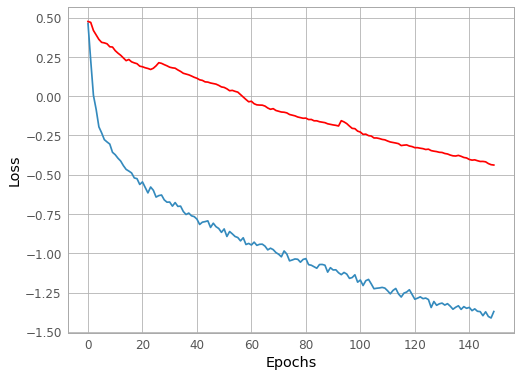

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')


Predicting...


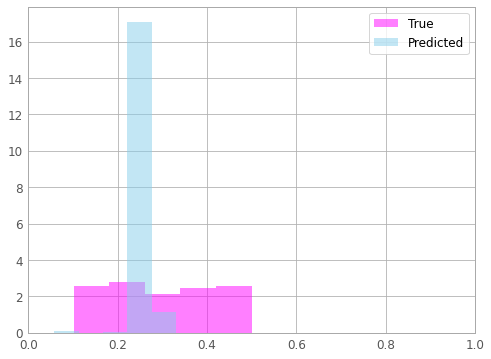

In [28]:
print("Predicting...")
print("====================")
LOAD_MODEL=False


Y_pred_DL = cnn(x_test)
plt.hist(y_test,label='True',alpha=0.5,density=True,bins=5,stacked=True,color='magenta')
plt.hist(np.asarray(Y_pred_DL.mean()),label='Predicted',alpha=0.5,density=True,bins=5,color='skyblue')
plt.xlim(0,1)
plt.legend()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


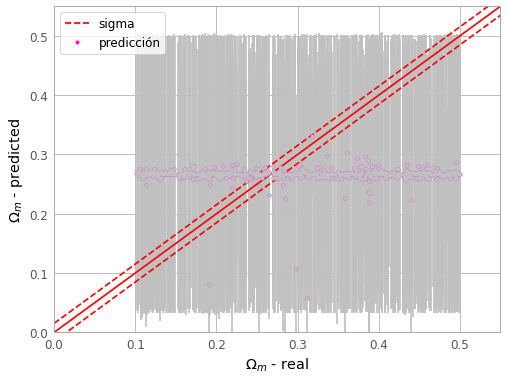

In [29]:
Y_pred_DL = cnn(x_test)

ypred=np.asarray(Y_pred_DL.mean())
error=np.asarray(Y_pred_DL.stddev())


plt.errorbar(y_test,ypred,yerr=error,color='silver',fmt='.')
plt.xlabel('$\\Omega_m$ - real')
plt.ylabel('$\\Omega_m$ - predicted')
plt.plot(np.linspace(0,0.6,10),np.linspace(0,0.6,10),'r-')
plt.plot(np.linspace(0,0.6,600),np.linspace(0,0.6,600)+np.std(ypred),'r--',label='sigma')
plt.plot(np.linspace(0,0.6,10),np.linspace(0,0.6,10)-np.std(ypred),'r--')
plt.plot(y_test, ypred, '.',color='magenta', label = 'predicción')
plt.ylim(0,0.55)
plt.xlim(0,0.55)
plt.legend()

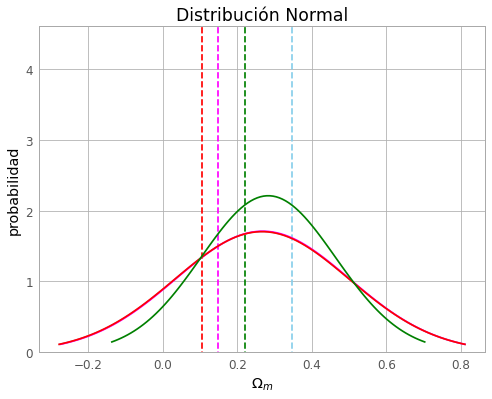

In [30]:

from scipy.stats import norm
import random
mu, sigma = ypred, error # media y desvio estandar
mu=mu[:,-1]
sigma=sigma[:,-1]

indice=np.array([])
indice = random.sample(range(0,len(mu)-1), 5)
newmu = np.array([])
newsigma = np.array([])
y_prueba = np.array([])
for i in indice:
  newmu = np.append(newmu, mu[i])
  newsigma = np.append(newsigma, sigma[i])
  y_prueba=np.append(y_prueba, y_test[indice])
mu = newmu
sigma=newsigma


normal = norm(mu, sigma)
x = np.linspace(normal.ppf(0.01),normal.ppf(0.99), 100)
fp = normal.pdf(x) # Función de Probabilidad
plt.plot(x[:,0], fp[:,0], color='skyblue')
plt.vlines(y_prueba[0],ymin=-3,ymax=7,linestyle='--', color='skyblue')

plt.plot(x[:,1], fp[:,1], color='magenta')
plt.vlines(y_prueba[1],ymin=-3,ymax=7,linestyle='--', color='magenta')

plt.plot(x[:,2], fp[:,2], color='red')
plt.vlines(y_prueba[2],ymin=-3,ymax=7,linestyle='--', color='red')

plt.plot(x[:,3], fp[:,3], color='green')
plt.vlines(y_prueba[3],ymin=-3,ymax=7,linestyle='--', color='green')

plt.title('Distribución Normal')
plt.ylabel('probabilidad')
plt.xlabel('$\Omega_m$')
#plt.legend(['$\Omega_m$='+str(a) for a in y_test[indice]])
plt.ylim(0,4.6)
plt.show()

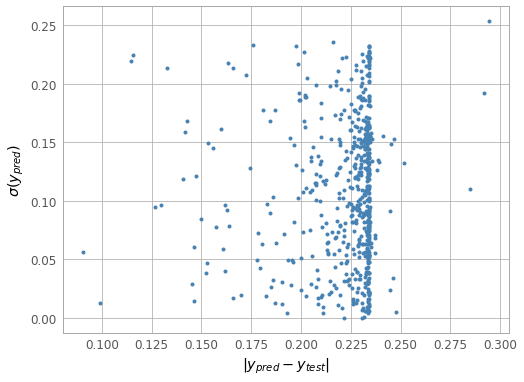

In [31]:
# Cálculo del error real

realError = np.array([])

for i in range(len(ypred)):
  realError = np.abs(np.append(realError, ypred[i] - y_test[i]))

plt.figure()
plt.plot(error, realError, '.', color='steelblue')
plt.xlabel(r"$\vert y_{pred}- y_{test} \vert$")
plt.ylabel(r"$\sigma(y_{pred})$")
plt.show()

Con el fin de analizar la generalidad del modelo se ha realizado el mismo procedimientos que se ha realizado para Illustris pero ahora para el caso del modelo SIMBA. De forma general se aprecia que no se ajustan nada bien las predicciones, por lo que existen fallas en nuestra red neuronal que no la hacen general.